In [1]:
base_path = '/tf/PatchCL-MedSeg-jiyu'
dataset_path = '/tf/dataset/0_data_dataset_voc_950_kidney'
output_dir = base_path + '/dataset/splits/kidney'

supervised_loss_path = base_path + '/supervised pre training_loss.csv'
SSL_loss_path = base_path + '/SSL_loss.csv'

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

In [2]:
import os
import sys
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

sys.path.append(base_path)

from utils.transform import Transform
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
from utils.datasets_PASCAL import PascalVOCDataset
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay
from utils.loss_file import save_loss

In [3]:
contrastive_batch_size = 32
img_size = 512
batch_size = 4
num_classes = 2
transform = Transform(img_size, num_classes)
embd_queues = Embedding_Queues(num_classes)
stochastic_approx = StochasticApprox(num_classes,0.5,0.8)
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = Network()
teacher_model = Network()

#Turning off gradients for teacher model
for param in teacher_model.parameters():
    param.requires_grad=False
    #Esuring mothe the models have same weight
teacher_model.load_state_dict(model.state_dict())
model.contrast=False
teacher_model.contrast = False

model = nn.DataParallel(model)
model = model.to(dev)
teacher_model = nn.DataParallel(teacher_model)
teacher_model=teacher_model.to(dev)

In [5]:
cross_entropy_loss=CE_loss(num_classes, image_size=img_size)
metrics=[smp.utils.metrics.IoU(threshold=0.5)]

optimizer_pretrain=torch.optim.Adam(model.parameters(),lr=0.001)
optimizer_ssl=torch.optim.SGD(model.parameters(),lr=0.007)
scheduler = PolynomialLRDecay(optimizer=optimizer_pretrain, max_decay_steps=200, end_learning_rate=0.0001, power=2.0)

In [6]:
labeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/labeled.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)
unlabeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/unlabeled.txt", image_size=img_size, root_dir=dataset_path, labeled=False, colormap=voc_mask_color_map)
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, labeled=True)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print('number of labeled_dataset: ', len(labeled_dataset))
print('number of unlabeled_dataset: ', len(unlabeled_dataset))
print('number of val_dataset: ', len(val_dataset))

number of labeled_dataset:  285
number of unlabeled_dataset:  570
number of val_dataset:  95


In [7]:
# 測試數據加載器
for images, masks in labeled_loader:
    print(images.shape, masks.shape)
    break

torch.Size([4, 3, 512, 512]) torch.Size([4, 512, 512])


Channel 0 pixel counts: {0.0: 238103, 1.0: 24041}
Channel 1 pixel counts: {0.0: 24041, 1.0: 238103}
Original masks shape:  torch.Size([4, 512, 512])
Multi-channel masks shape:  torch.Size([4, 2, 512, 512])


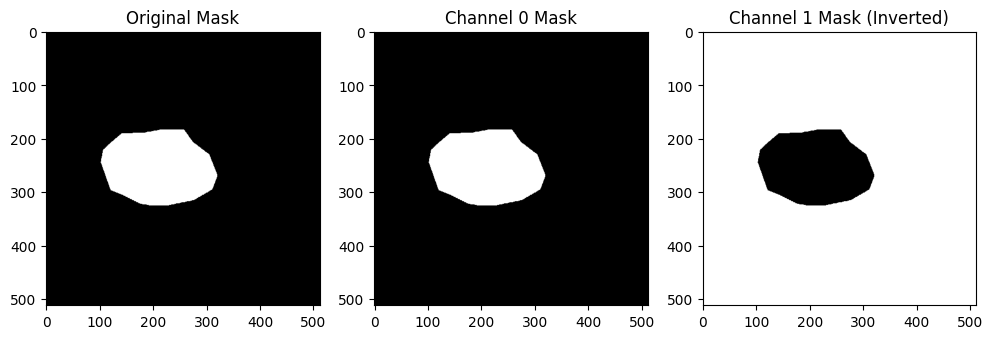

In [8]:
# 創建一個新的形狀為 [8, 2, 256, 256] 的張量
multi_channel_masks = torch.zeros((masks.size(0), 2, masks.size(1), masks.size(2)), dtype=torch.float32)

# 將單通道遮罩轉換為多通道遮罩
multi_channel_masks[:, 0, :, :] = masks.float()  # 原始遮罩
multi_channel_masks[:, 1, :, :] = 1 - masks.float()  # 反轉遮罩

# 檢查一個樣本中的唯一值和像素計數
imgs_np = multi_channel_masks[0, 0].numpy()
unique, counts = np.unique(imgs_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("Channel 0 pixel counts:", pixel_counts)

imgs_np = multi_channel_masks[0, 1].numpy()
unique, counts = np.unique(imgs_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("Channel 1 pixel counts:", pixel_counts)
print("Original masks shape: ", masks.shape)
print("Multi-channel masks shape: ", multi_channel_masks.shape)

# 顯示原圖和多通道遮罩
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(masks[0].numpy(), cmap='gray')
plt.title("Original Mask")
plt.subplot(1, 3, 2)
plt.imshow(multi_channel_masks[0, 0].numpy(), cmap='gray')
plt.title("Channel 0 Mask")
plt.subplot(1, 3, 3)
plt.imshow(multi_channel_masks[0, 1].numpy(), cmap='gray')
plt.title("Channel 1 Mask (Inverted)")
plt.show()

In [9]:
#Send psudo masks & imgs to cpu
p_masks = multi_channel_masks
imgs = images

print(imgs.shape)

#get classwise patch list
patch_list = _get_patches(imgs, p_masks,classes=num_classes,background=True,img_size=img_size,patch_size=contrastive_batch_size)

#stochastic approximation filtering and threshold update
#qualified_patch_list = stochastic_approx.update(patch_list)
qualified_patch_list = patch_list

#make augmentations for teacher model
augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)


#convert to tensor
aug_tensor_patch_list=[]
qualified_tensor_patch_list=[]
for i in range(len(augmented_patch_list)):
    if augmented_patch_list[i] is not None:
        aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
        qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
    else:
        aug_tensor_patch_list.append(None)
        qualified_tensor_patch_list.append(None)

torch.Size([4, 3, 512, 512])


In [ ]:
#get embeddings of qualified patches through student model
model=model.train()
model.module.contrast=True
student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)
print('student_emb_list len: ', len(student_emb_list))


#get embeddings of augmented patches through teacher model
teacher_model.train()
teacher_model.module.contrast = True
teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)
print('teacher_embedding_list len: ', len(teacher_embedding_list))

#enqueue these
embd_queues.enqueue(teacher_embedding_list)

#calculate PCGJCL loss
PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, 128, 0.2 , 4, psi=4096)
PCGJCL_loss = PCGJCL_loss.to(dev)
print('PCGJCL_loss: ', PCGJCL_loss)

model.module.contrast=False
#calculate supervied loss
imgs, multi_channel_masks =imgs.to(dev), multi_channel_masks.to(dev)
out = model(imgs)
print('masks shape: ', multi_channel_masks.shape)
print('output shape: ', out.shape)

supervised_loss = cross_entropy_loss(out,multi_channel_masks)
supervised_loss = supervised_loss.to(dev)

print('supervised_loss: ', supervised_loss)

#total loss
loss = supervised_loss + 0.5*PCGJCL_loss

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


In [ ]:
for c_epochs in range(100): #100 epochs supervised pre training
    step=0
    min_loss = math.inf
    epoch_loss=0
    print('Epoch ',c_epochs)
    
    total_supervised_loss = 0
    total_contrastive_loss = 0 
    
    for imgs, masks in labeled_loader:
        print("masks shape: ", masks.shape)
        # 創建一個新的形狀為 [8, 2, 256, 256] 的張量
        multi_channel_masks = torch.zeros((masks.size(0), 2, masks.size(1), masks.size(2)), dtype=torch.float32)
        # 將單通道遮罩轉換為多通道遮罩
        multi_channel_masks[:, 0, :, :] = masks.float()  # 原始遮罩
        multi_channel_masks[:, 1, :, :] = 1 - masks.float()  # 反轉遮罩

        t1=time.time()
        with torch.no_grad():

            #Send psudo masks & imgs to cpu
            p_masks = multi_channel_masks
            imgs = imgs

            #get classwise patch list
            patch_list = _get_patches(
                imgs, p_masks,
                classes=num_classes,
                background=True,
                img_size=img_size,
                patch_size=contrastive_batch_size
            )

            #stochastic approximation filtering and threshold update
            #qualified_patch_list = stochastic_approx.update(patch_list)
            qualified_patch_list = patch_list

            #make augmentations for teacher model
            augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)


            #convert to tensor
            aug_tensor_patch_list=[]
            qualified_tensor_patch_list=[]
            for i in range(len(augmented_patch_list)):
                if augmented_patch_list[i] is not None:
                    aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
                    qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
                else:
                    aug_tensor_patch_list.append(None)
                    qualified_tensor_patch_list.append(None)


        #get embeddings of qualified patches through student model
        model=model.train()
        model.module.contrast=True
        student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)

        #get embeddings of augmented patches through teacher model
        teacher_model.train()
        teacher_model.contrast = True
        teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)

        #enqueue these
        embd_queues.enqueue(teacher_embedding_list)

        #calculate PCGJCL loss
        PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, 128, 0.2 , 4, psi=4096)        
        print('PCGJCL_loss: ', PCGJCL_loss.item())
        
        #calculate supervied loss
        imgs, multi_channel_masks =imgs.to(dev), multi_channel_masks.to(dev)
        model.module.contrast=False
        out = model(imgs)
        
        supervised_loss = cross_entropy_loss(out,multi_channel_masks)
        print('supervised_loss: ', supervised_loss.item())

        #total loss
        PCGJCL_loss = PCGJCL_loss.to(dev)
        loss = supervised_loss + 0.5*PCGJCL_loss
        
        total_contrastive_loss += PCGJCL_loss.item()
        total_supervised_loss += supervised_loss.item()
        epoch_loss+=loss.item()

        #backpropagate
        loss.backward()
        optimizer_pretrain.step()

        for param_stud, param_teach in zip(model.parameters(),teacher_model.parameters()):
            param_teach.data.copy_(0.001*param_stud + 0.999*param_teach)

        #Extras
        t2=time.time()
        print('step ', step, 'loss: ',loss, ' & time: ',t2-t1)
        step+=1
        
    avg_epoch_loss = epoch_loss / len(labeled_loader)
    avg_supervised_loss = total_supervised_loss / len(labeled_loader)
    avg_contrastive_loss = total_contrastive_loss / len(labeled_loader)
    
    save_loss(total_loss = f"{avg_epoch_loss:.4f}", 
          supervised_loss=f"{avg_supervised_loss:.4f}", 
          contrastive_loss=f"{avg_contrastive_loss:.4f}", 
          consistency_loss = 0 ,
          filename=supervised_loss_path)
    if epoch_loss < min_loss:
        torch.save(model,'./best_contrast.pth')

In [ ]:
for c_epochs in range(200): #200 epochs supervised SSL
    step=0
    min_loss = math.inf
    epoch_loss=0
    print('Epoch ',c_epochs)
    
    total_supervised_loss = 0
    total_contrastive_loss = 0
    total_consistency_loss = 0

    labeled_iterator = iter(labeled_loader)
    
    for imgs in unlabeled_loader:

        t1=time.time()
        with torch.no_grad():

            #send imgs to dev
            imgs = imgs.to(dev)

            #set model in Eval mode
            model = model.eval()

            #Get pseudo masks
            model.module.contrast=False
            p_masks = model(imgs)

            #Send psudo masks & imgs to cpu
            p_masks=masks
            p_masks = p_masks.to('cpu').detach()
            imgs = imgs.to('cpu').detach()

            #Since we use labeled data for PCGJCL as well
            imgs2, masks2 = next(labeled_iterator)

            #concatenating unlabeled and labeled sets
            p_masks = torch.cat([p_masks,masks2],dim=0)
            imgs = torch.cat([imgs,imgs2],dim=0)
            
            multi_channel_masks = torch.zeros((p_masks.size(0), 2, p_masks.size(1), p_masks.size(2)), dtype=torch.float32)
            # 將單通道遮罩轉換為多通道遮罩
            multi_channel_masks[:, 0, :, :] = p_masks.float()  # 原始遮罩
            multi_channel_masks[:, 1, :, :] = 1 - p_masks.float()  # 反轉遮罩

            #get classwise patch list
            patch_list = _get_patches(
                imgs, multi_channel_masks,
                classes=num_classes,
                background=True,
                img_size=img_size,
                patch_size=contrastive_batch_size
            )

            #stochastic approximation filtering and threshold update
            qualified_patch_list = stochastic_approx.update(patch_list)


            #make augmentations for teacher model
            augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)

            #convert to tensor
            aug_tensor_patch_list=[]
            qualified_tensor_patch_list=[]
            for i in range(len(augmented_patch_list)):
                if augmented_patch_list[i] is not None:
                    aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
                    qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
                else:
                    aug_tensor_patch_list.append(None)
                    qualified_tensor_patch_list.append(None)


        #get embeddings of qualified patches through student model
        model=model.train()
        model.module.contrast=True
        student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)

        #get embeddings of augmented patches through teacher model
        teacher_model.train()
        teacher_model.module.contrast = True
        teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)

        #enqueue these
        embd_queues.enqueue(teacher_embedding_list)
        PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, 128, 0.2 , 4, psi=4096)     

        #calculate supervied loss
        imgs2, multi_channel_masks =imgs2.to(dev), multi_channel_masks.to(dev)
        
        model.module.contrast = False
        out = model(imgs)
        supervised_loss = cross_entropy_loss(out,multi_channel_masks)
        
        teacher_model.module.contrast = False
        #Consistency Loss
        consistency_loss=consistency_cost(model,teacher_model,imgs,multi_channel_masks)
        
        supervised_loss = supervised_loss.to(dev)
        PCGJCL_loss = PCGJCL_loss.to(dev)
        consistency_loss = consistency_loss.to(dev)
        
        total_supervised_loss += supervised_loss.item()
        total_contrastive_loss += PCGJCL_loss.item()
        total_consistency_loss += consistency_loss.item() 
        
        print("supervised_loss: ", supervised_loss.item())
        print("PCGJCL_loss: ", PCGJCL_loss.item())
        print("consistency_loss: ", consistency_loss.item())
        
        #total loss
        loss = supervised_loss + 0.5*PCGJCL_loss + 4*consistency_loss
        epoch_loss += loss.item()
        
        #backpropagate
        loss.backward()
        optimizer_ssl.step()
        scheduler.step()


        for param_stud, param_teach in zip(model.parameters(),teacher_model.parameters()):
            param_teach.data.copy_(0.001*param_stud + 0.999*param_teach)

        #Extras
        t2=time.time()
        print('step ', step, 'loss: ',loss, ' & time: ',t2-t1)
        step+=1
        
    avg_epoch_loss = epoch_loss / len(unlabeled_loader)
    avg_supervised_loss = total_supervised_loss / len(unlabeled_loader)
    avg_contrastive_loss = total_contrastive_loss / len(unlabeled_loader)
    avg_consistency_loss = total_consistency_loss / len(unlabeled_loader)

    save_loss(total_loss= f"{avg_epoch_loss:.4f}", 
              supervised_loss=f"{avg_supervised_loss:.4f}", 
              contrastive_loss=f"{avg_contrastive_loss:.4f}", 
              consistency_loss=f"{avg_consistency_loss:.4f}",
              filename=SSL_loss_path)
    
    if epoch_loss < min_loss:
        torch.save(model,'./best_contrast.pth')